In [1]:
################
# SVM Definition
################

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# I pulled this example from the code provided in class.
class SVM:
    def __init__(self, C=1.0, kernel='rbf', sigma=0.1, degree=2):
        self.C = C
        # Define the poly function
        if kernel == 'poly':
            self.kernel = self._polynomial_kernel
            self.C = 1
            self.degree = degree
        # Define the rbf function
        elif kernel == 'rbf':
            self.kernel = self._rbf_kernel
            self.sigma = sigma
        # Define the linear function
        else:
            self.kernel = self._linear_kernel

        self.X = None # inputs
        self.y = None # target
        self.alpha = None # lagrangian multiplier, these are the coefficents we are trying to solve for, for support vectors 
        self.b = 0 # bias
        self.ones = None

    def _rbf_kernel(self, X_t, X):
        # Define the rbf function using the forumla from class
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X_t[:, np.newaxis] - X[np.newaxis, :], axis=2) ** 2)

    def _polynomial_kernel(self, X_t, X):
        # distance between two points in polynomial space is dot product squared
        return (X_t.dot(X.T)) ** self.degree

    def _linear_kernel(self, X, X_t):
        # Linear dot product, same as last time
        return (X.dot(X_t.T))

    def fit(self, X, y, lr=1e-3, epochs=200, plot=True):

        self.X = X
        self.y = y

        # (N,)

        # we use alpha instead of lambda, this is equivielent to number of data points in X
        self.alpha = np.ones(X.shape[0])
        # self.alpha = np.random.random(X.shape[0]) # lagrangian multiplier lambdas (can't use lambda as variable name)
        self.b = 0 # bias
        # (N,)
        self.ones = np.ones(X.shape[0])

        # (N,N) =             (N,N) *        (N,N)
        y_outer = np.outer(y, y)

        # This replaces the linear dot product, with a kernel function
        y_iy_jk_ij = y_outer * self.kernel(X, X)

        gains = []
        for _ in range(epochs):
            # (500,)  =    (500,)      (N,N).(N,)=(N,)
            gradient = self.ones - y_iy_jk_ij.dot(self.alpha)

            self.alpha = self.alpha + lr * gradient

            # Use C here to adjust the margin, greater C means smaller margin
            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0

            # the lagrangian formulation of the solution
            gain = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_iy_jk_ij)

            gains.append(gain)
            # self.plot_decision_boundary()

        # This index where lambda is greater than 0 and less than c is index of our support vector
        index = np.where(self.alpha > 0 & (self.alpha < self.C))[0]
        # (m,)= (m,)       (n,).(n,m)= (m,)

        # Calcuate the bias
        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))
        # Alternative code
        # b_i = y[index] - np.sum((self.alpha * y).reshape(-1, 1)*self.kernel(X, X[index]), axis=0)
        self.b = np.mean(b_i)
        if plot:
            plt.plot(gains)
            plt.title("gains per epochs")
            plt.show()

    # Calculates w_transpose * X
    def _decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b

    # Prediction is done by positive or negative of the decsion function
    def predict(self, X):
        return np.sign(self._decision_function(X))

    def score(self, X, y):
        # Just get the mean number of correct predictions
        y_hat = self.predict(X)
        return np.mean(y == y_hat)

    def plot_decision_boundary(self):
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap=plt.cm.Paired, alpha=.5)
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self._decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        # highlight the support vectors
        ax.scatter(self.X[:, 0][self.alpha > 0.], self.X[:, 1][self.alpha > 0.], s=50,
                   linewidth=1, facecolors='none', edgecolors='k')

        plt.show()


class SampleData:
    # Make a simple linearly seperable shapes
    def get_binary(self, n_samples, noise=0.05, random_state=3):
        n = n_samples
        blobs = datasets.make_blobs(n_samples=n, centers=2, n_features=2, cluster_std=2, random_state=random_state)
        return blobs[0], blobs[1]

    # Create moon shapes which are not linearly seperable  due to the curve of the moon
    def get_moon(self, n_samples, noise=0.05):
        noisy_moons = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=6)
        return noisy_moons[0], noisy_moons[1]

    # Create a donut inside another donut, not linearly seperable
    def get_donut(self, n_samples, noise=0.05, factor=0.5):
        noisy_circles = datasets.make_circles(n_samples=n_samples, factor=factor, noise=noise)
        return noisy_circles[0], noisy_circles[1]

    def plot(self, X, y):
        ax = plt.gca()
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.show()



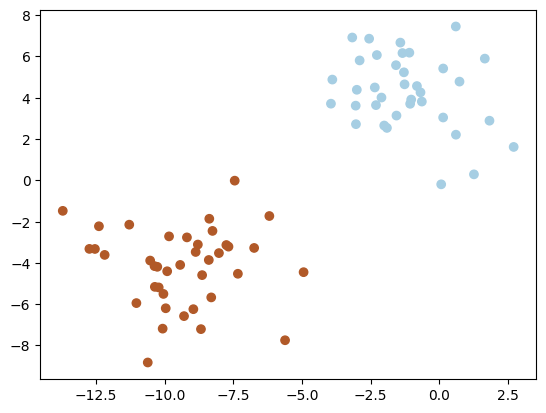

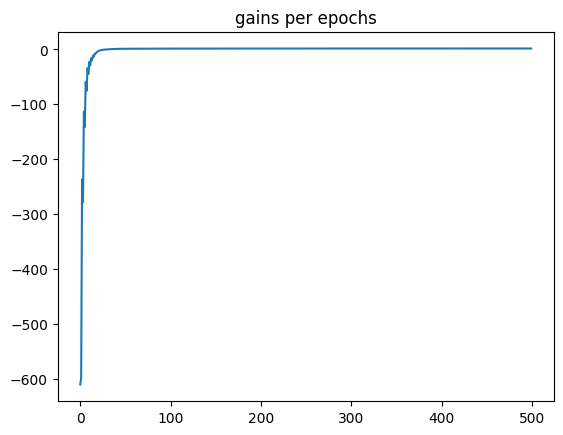

train score linear: 1.0


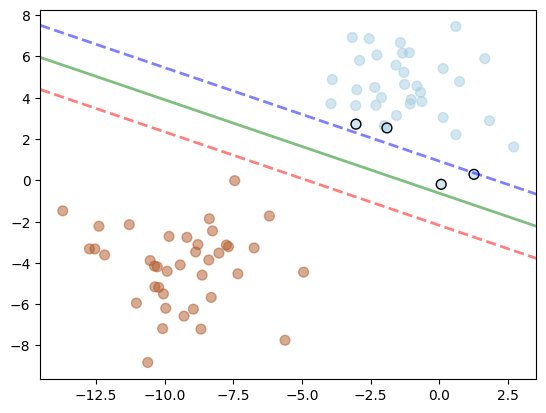

test score linear: 1.0
ok


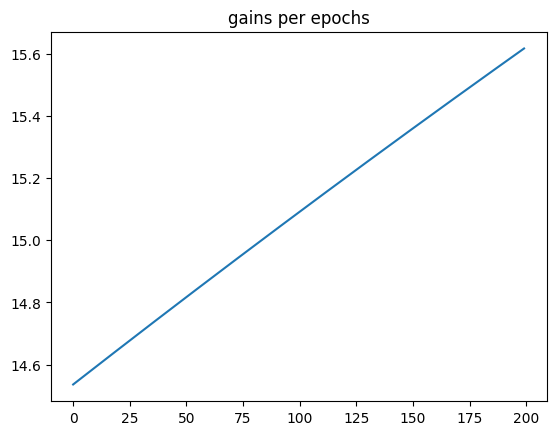

train score rbf: 1.0


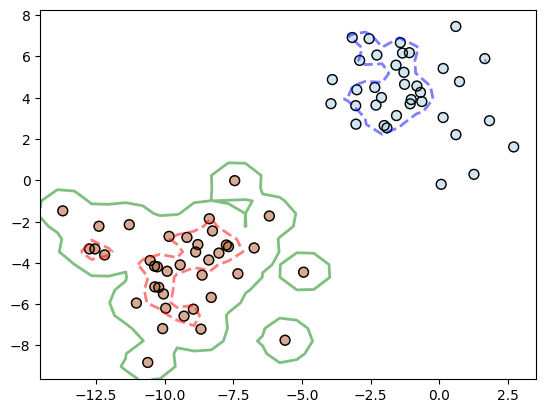

test score rbf: 1.0
ok


In [2]:
sample = SampleData()

# Binary DATA
X, y = sample.get_binary(n_samples=100, random_state=1)
y[y == 0] = -1
# Split the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
sample.plot(X_train, y_train)

# Train the model - linear
svm = SVM(C=1, kernel='linear', sigma=0.5)
svm.fit(X_train, y_train, lr=.001, epochs=500)
print("train score linear:", svm.score(X_train, y_train))
svm.plot_decision_boundary()
print("test score linear:", svm.score(X_test, y_test))
print('ok')

# Train the model - rbf
svm = SVM(C=1, kernel='rbf', sigma=0.5)
svm.fit(X_train, y_train, lr=.0001)
print("train score rbf:", svm.score(X_train, y_train))
svm.plot_decision_boundary()
print("test score rbf:", svm.score(X_test, y_test))
print('ok')

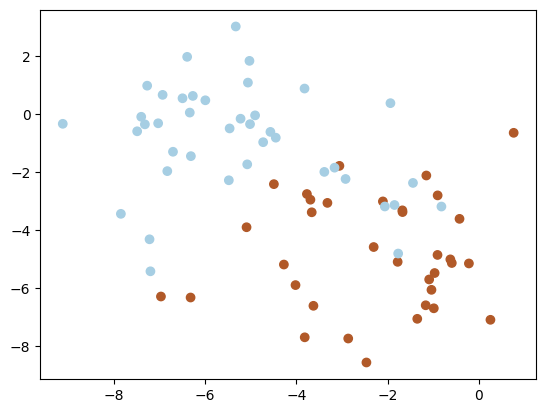

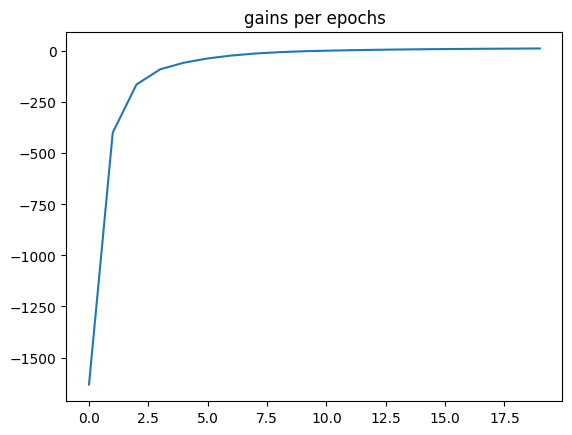

train score linear: 0.8666666666666667


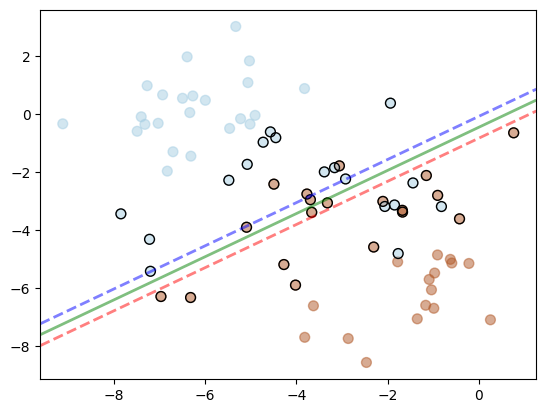

test score linear: 0.8
ok


In [3]:
# Binary DATA
X, y = sample.get_binary(n_samples=100, random_state=33)
y[y == 0] = -1
# Split the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
sample.plot(X_train, y_train)


# Train the model - linear
svm = SVM(C=0.8, kernel='linear', sigma=0.5)
svm.fit(X_train, y_train, lr=.001, epochs=20)
print("train score linear:", svm.score(X_train, y_train))
svm.plot_decision_boundary()
print("test score linear:", svm.score(X_test, y_test))
print('ok')

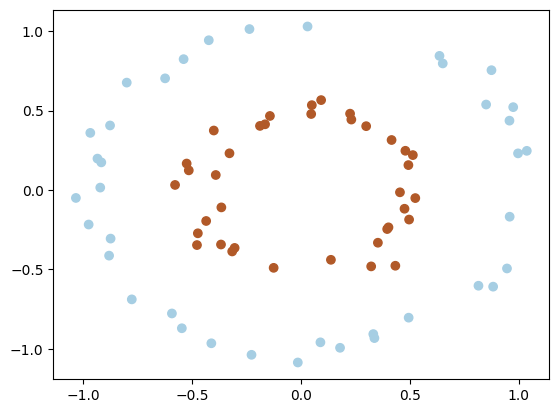

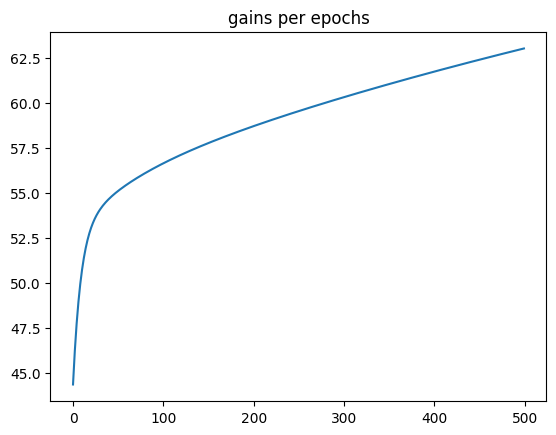

train score: 1.0


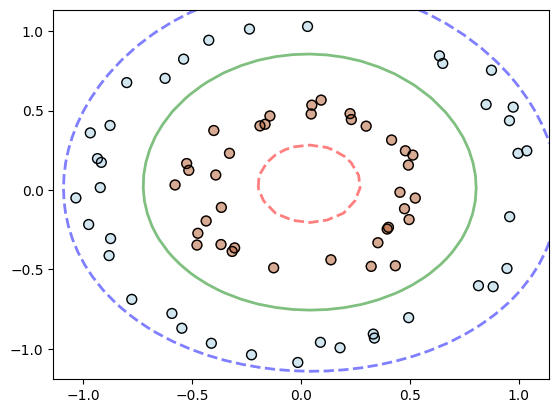

test score: 1.0
ok


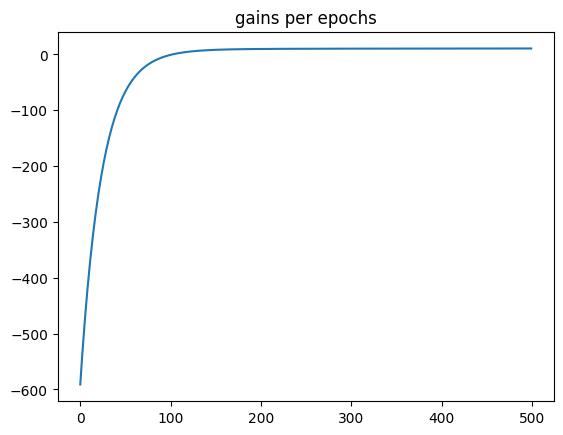

train score: 1.0


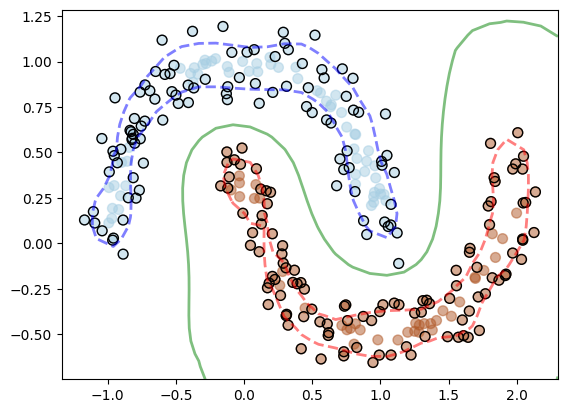

test score: 1.0


In [4]:
X, y = sample.get_donut(n_samples=100, noise=.05)
y[y == 0] = -1

# Split the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
sample.plot(X_train, y_train)


# Train the model
svm = SVM(C=5.0, kernel='rbf', sigma=2)
svm.fit(X_train, y_train, lr=1e-3, epochs=500)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()
print("test score:", svm.score(X_test, y_test))
print('ok')

X, y = sample.get_moon(n_samples=400, noise=0.1)
y[y == 0] = -1

# Split the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Train the model
svm = SVM(C=0.5, kernel='rbf', sigma=0.3)
svm.fit(X_train, y_train, lr=1e-3, epochs=500)
print("train score:", svm.score(X, y))
svm.plot_decision_boundary()

print("test score:", svm.score(X_test, y_test))

# Stock predictions

In [5]:
# Try some predictions with an SVM:

# https://www.geeksforgeeks.org/predicting-stock-price-direction-using-support-vector-machines/

from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

import pandas as pd 
import numpy as np 
  
# To plot 
import matplotlib.pyplot as plt 

import warnings 
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('all_stocks_5yr.csv')
# Filter down to just one stock
df = df.rename(columns={'Name': 'Ticks'})
df.head()

,date,open,high,low,close,volume,Ticks
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [7]:
min_date = df['date'].min()
max_date = df['date'].max()
print("Min date:", min_date)
print("Max date:", max_date)

Min date: 2013-02-08
Max date: 2018-02-07


In [8]:
unique_values = df['Ticks'].unique()
print(unique_values)

['AAL' 'AAPL' 'AAP' 'ABBV' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADM' 'ADP'
 'ADSK' 'ADS' 'AEE' 'AEP' 'AES' 'AET' 'AFL' 'AGN' 'AIG' 'AIV' 'AIZ' 'AJG'
 'AKAM' 'ALB' 'ALGN' 'ALK' 'ALLE' 'ALL' 'ALXN' 'AMAT' 'AMD' 'AME' 'AMGN'
 'AMG' 'AMP' 'AMT' 'AMZN' 'ANDV' 'ANSS' 'ANTM' 'AON' 'AOS' 'APA' 'APC'
 'APD' 'APH' 'APTV' 'ARE' 'ARNC' 'ATVI' 'AVB' 'AVGO' 'AVY' 'AWK' 'AXP'
 'AYI' 'AZO' 'A' 'BAC' 'BAX' 'BA' 'BBT' 'BBY' 'BDX' 'BEN' 'BF.B' 'BHF'
 'BHGE' 'BIIB' 'BK' 'BLK' 'BLL' 'BMY' 'BRK.B' 'BSX' 'BWA' 'BXP' 'CAG'
 'CAH' 'CAT' 'CA' 'CBG' 'CBOE' 'CBS' 'CB' 'CCI' 'CCL' 'CDNS' 'CELG' 'CERN'
 'CFG' 'CF' 'CHD' 'CHK' 'CHRW' 'CHTR' 'CINF' 'CI' 'CLX' 'CL' 'CMA' 'CMCSA'
 'CME' 'CMG' 'CMI' 'CMS' 'CNC' 'CNP' 'COF' 'COG' 'COL' 'COO' 'COP' 'COST'
 'COTY' 'CPB' 'CRM' 'CSCO' 'CSRA' 'CSX' 'CTAS' 'CTL' 'CTSH' 'CTXS' 'CVS'
 'CVX' 'CXO' 'C' 'DAL' 'DE' 'DFS' 'DGX' 'DG' 'DHI' 'DHR' 'DISCA' 'DISCK'
 'DISH' 'DIS' 'DLR' 'DLTR' 'DOV' 'DPS' 'DRE' 'DRI' 'DTE' 'DUK' 'DVA' 'DVN'
 'DWDP' 'DXC' 'D' 'EA' 'EBAY' 'ECL' 'ED' 'EFX' 'EIX' 'E

Test accuracy: 0.5714285714285714
Test precision: 0.5714285714285714
Test precision: 1.0
Test precision: 0.7272727272727273
Train accuracy: 0.535253227408143


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


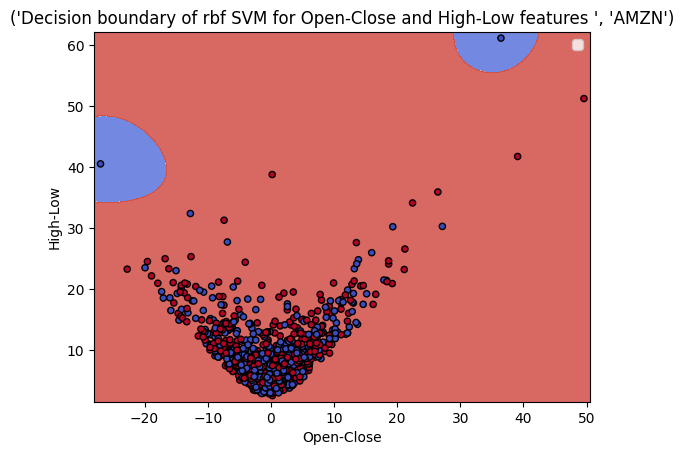

Test accuracy: 0.5555555555555556
Test precision: 0.5798816568047337
Test precision: 0.7050359712230215
Test precision: 0.6363636363636364
Train accuracy: 0.5441906653426017


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


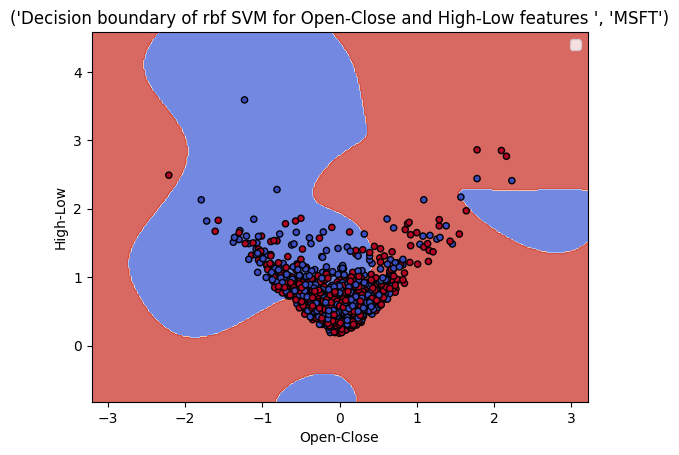

Test accuracy: 0.5873015873015873
Test precision: 0.6390532544378699
Test precision: 0.7152317880794702
Test precision: 0.675
Train accuracy: 0.548162859980139


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


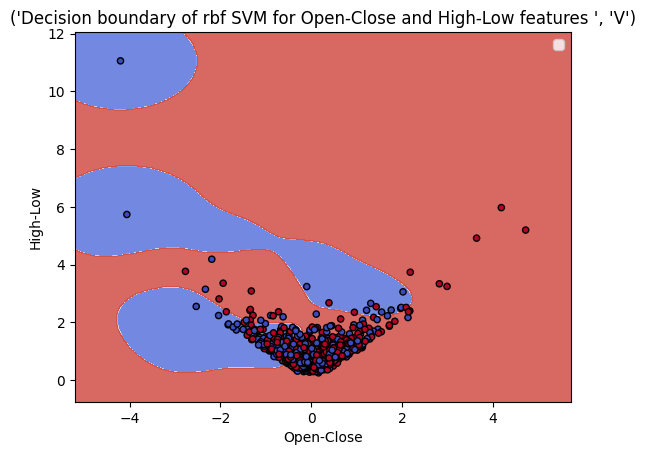

Test accuracy: 0.5912698412698413
Test precision: 0.5991561181434599
Test precision: 0.9466666666666667
Test precision: 0.7338501291989664
Train accuracy: 0.5600794438927508


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


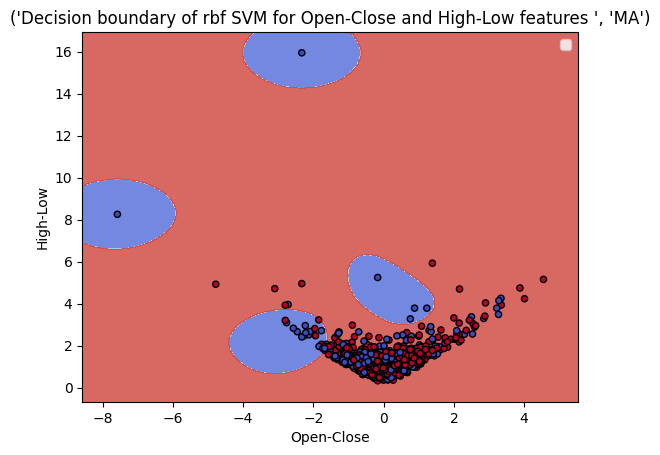

Test accuracy: 0.4444444444444444
Test precision: 0.5365853658536586
Test precision: 0.15384615384615385
Test precision: 0.2391304347826087
Train accuracy: 0.5322740814299901


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


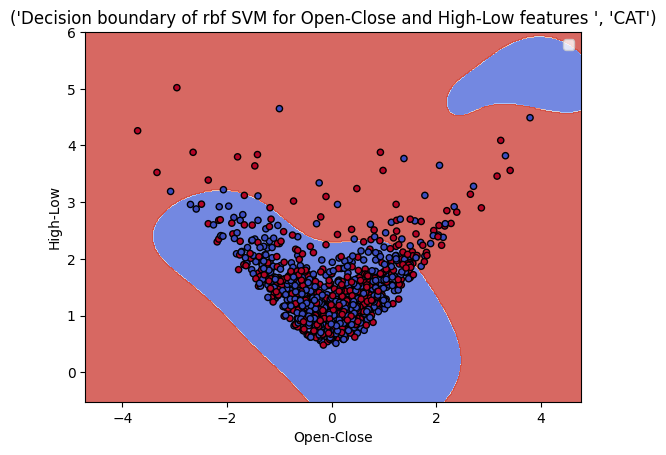

In [9]:
#############
# Section One
#############

decision_names = ["AMZN", "MSFT", "V", "MA", "CAT"]

# # Try plotting the decision boundary, this takes a long time
# # From here: https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface

# AMZN especially takes a while, removed to save time on running the code

for name in decision_names:
    # Filter down to just one stock
    df = df.rename(columns={'Name': 'Ticks'})
    
    v = df.loc[df['Ticks'] == name]
    v.index = pd.to_datetime(v['date']) 
    
    v = v.drop(['date'], axis='columns') 
    
    # Create predictor variables 
    v['Open-Close'] = v['open'] - v['close']
    v['High-Low'] = v['high'] - v['low']
      
    # Store all predictor variables in a variable X 
    X = v[['Open-Close', 'High-Low']] 
    X.head() 
    
    # If the next day close is greater than the current day close, classify as buy (1)
    # else it is a no-position (0)
    y = np.where(v['close'].shift(-1) > v['close'], 1, 0) 
    
    
    # Split and train on a buy and a sell
    split_percentage = 0.8
    split = int(split_percentage*len(v)) 
      
    # Train data set 
    X_train = X[:split] 
    y_train = y[:split] 
      
    # Test data set 
    X_test = X[split:] 
    y_test = y[split:]
    
    svm = SVC(kernel ='rbf', C=1)
    cls = svm.fit(X_train, y_train)
    
    y_pred = cls.predict(X_test)
    y_pred_train = cls.predict(X_train)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Test accuracy:", accuracy)
    print("Test precision:", precision)
    print("Test precision:", recall)
    print("Test precision:", f1)
    
    accuracy = accuracy_score(y_train, y_pred_train)
    print("Train accuracy:", accuracy)
    
    
    
    
    def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return xx, yy
    
    def plot_contours(ax, clf, xx, yy, **params):
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out
    
    fig, ax = plt.subplots()
    # title for the plots
    title = ('Decision boundary of rbf SVM for Open-Close and High-Low features ', name)
    
    # Get Y
    y = y_train
    
    # Set-up grid for plotting.
    X0, X1 = X_train['Open-Close'].to_numpy(), X_train['High-Low'].to_numpy()
    xx, yy = make_meshgrid(X0, X1)
    
    plot_contours(ax, cls, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_ylabel('High-Low')
    ax.set_xlabel('Open-Close')
    # ax.set_xticks(())
    # ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

Modeling  AMZN
            Open-Close  High-Low
date                            
2013-02-08       -0.55     4.695
2013-02-11        5.99     6.650
2013-02-12        0.49     3.160
2013-02-13       -7.94     9.660
2013-02-14       -1.87     5.250
...                ...       ...
2018-02-01       55.00    74.740
2018-02-02       47.44    84.000
2018-02-05       12.62   138.260
2018-02-06      -81.38    92.200
2018-02-07       32.22    45.840

[1259 rows x 2 columns]
Test accuracy: 0.5714285714285714
Train accuracy: 0.535253227408143
              open      high       low   close   volume Ticks  Open-Close  \
date                                                                        
2017-02-08  812.69  821.4790  812.5000  819.71  2857985  AMZN       -7.02   
2017-02-09  821.60  825.0000  819.7100  821.36  2484948  AMZN        0.24   
2017-02-10  823.82  828.0000  822.8500  827.46  2429609  AMZN       -3.64   
2017-02-13  831.62  842.9999  828.5500  836.53  4172618  AMZN       -4.91   
2

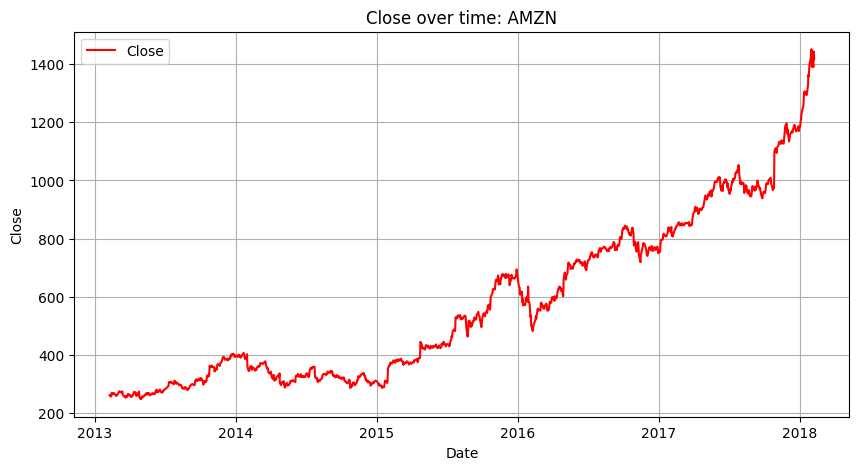

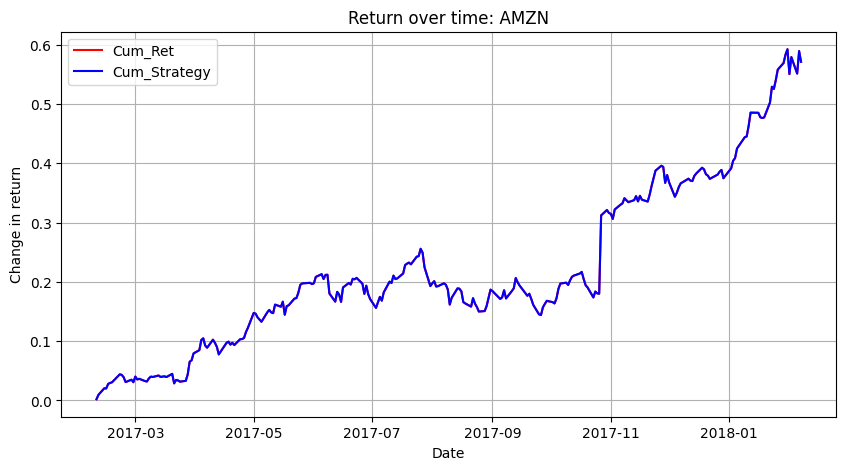

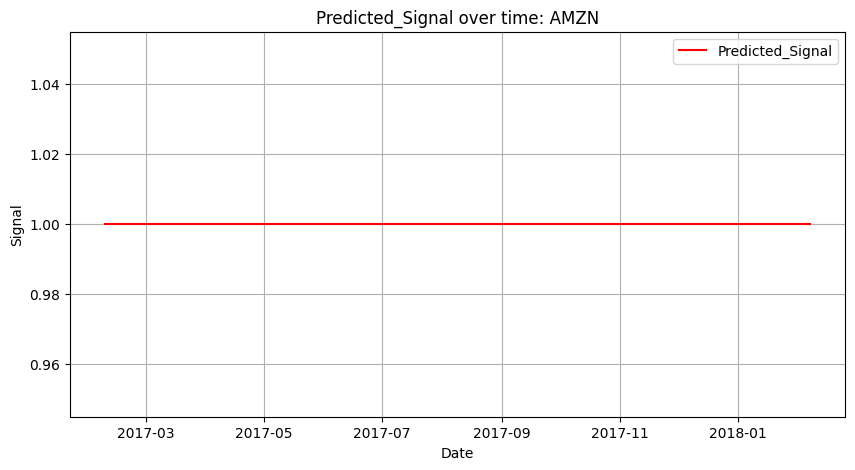

Modeling  AAPL
            Open-Close  High-Low
date                            
2013-02-08     -0.1400    1.5086
2013-02-11     -0.4900    1.6700
2013-02-12      1.6586    2.0909
2013-02-13      0.0286    1.4886
2013-02-14     -0.2957    1.0886
...                ...       ...
2018-02-01     -0.6150    1.8600
2018-02-02      5.5000    6.7000
2018-02-05      2.6100    7.8800
2018-02-06     -8.2000    9.7200
2018-02-07      3.5450    4.3315

[1259 rows x 2 columns]
Test accuracy: 0.5
Train accuracy: 0.5362462760675273
              open     high     low   close    volume Ticks  Open-Close  \
date                                                                      
2017-02-08  131.35  132.220  131.22  132.04  23004072  AAPL       -0.69   
2017-02-09  131.65  132.445  131.12  132.42  28349859  AAPL       -0.77   
2017-02-10  132.46  132.940  132.05  132.12  20065458  AAPL        0.34   
2017-02-13  133.08  133.820  132.75  133.29  23035421  AAPL       -0.21   
2017-02-14  133.47  135.090

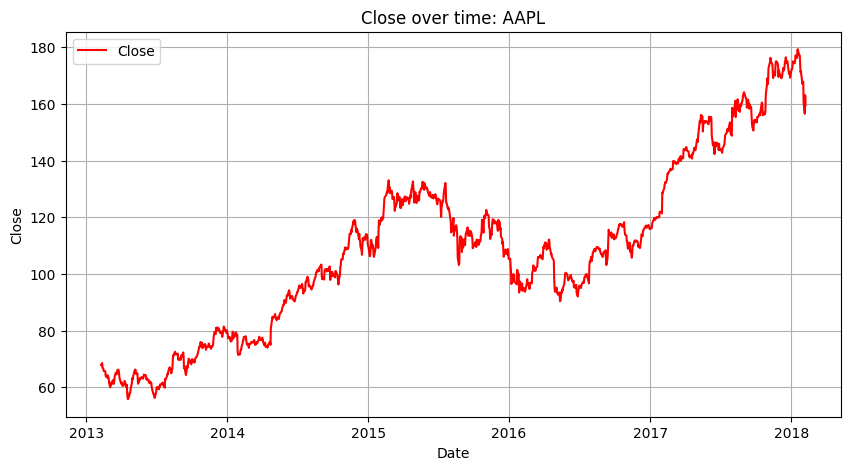

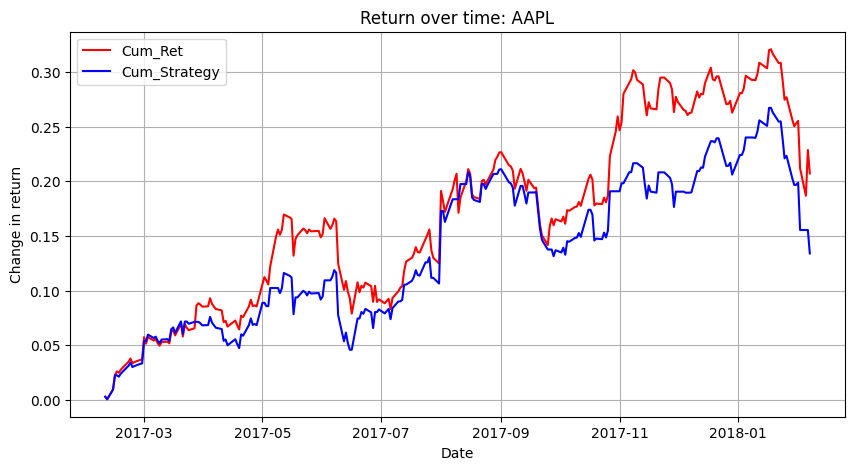

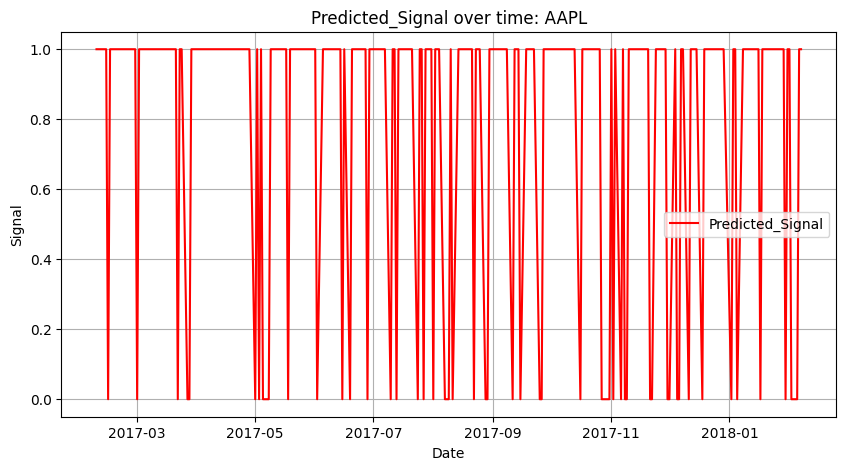

Modeling  MSFT
            Open-Close  High-Low
date                            
2013-02-08       -0.20    0.4000
2013-02-11       -0.21    0.4200
2013-02-12        0.00    0.2500
2013-02-13       -0.10    0.2300
2013-02-14       -0.12    0.1900
...                ...       ...
2018-02-01        0.53    2.4887
2018-02-02        1.86    2.4700
2018-02-05        2.56    5.2400
2018-02-06       -4.44    6.2250
2018-02-07        0.88    2.5700

[1259 rows x 2 columns]
Test accuracy: 0.5555555555555556
Train accuracy: 0.5441906653426017
             open    high     low  close    volume Ticks  Open-Close  \
date                                                                   
2017-02-08  63.57  63.810  63.220  63.34  18096358  MSFT        0.23   
2017-02-09  63.52  64.435  63.320  64.06  22644443  MSFT       -0.54   
2017-02-10  64.25  64.300  63.975  64.00  18170729  MSFT        0.25   
2017-02-13  64.24  64.860  64.130  64.72  22920101  MSFT       -0.48   
2017-02-14  64.41  64.720  64.

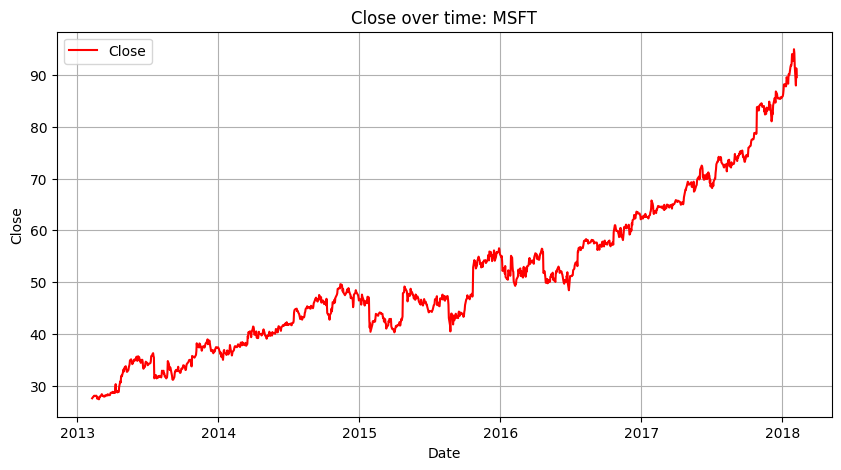

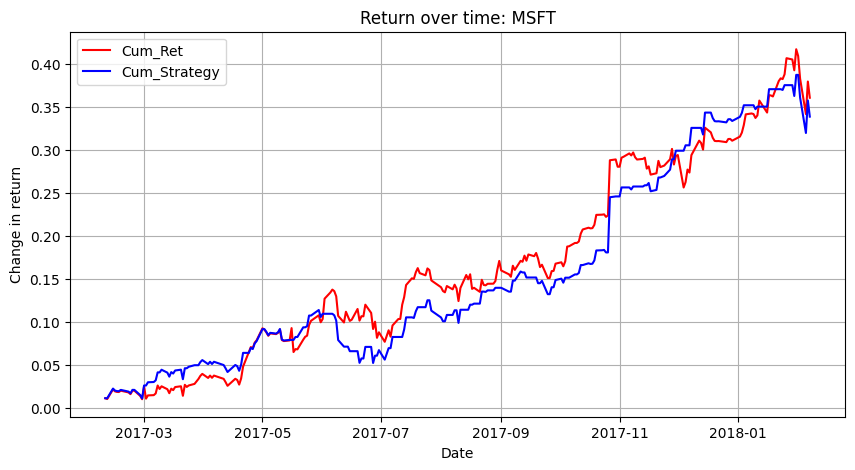

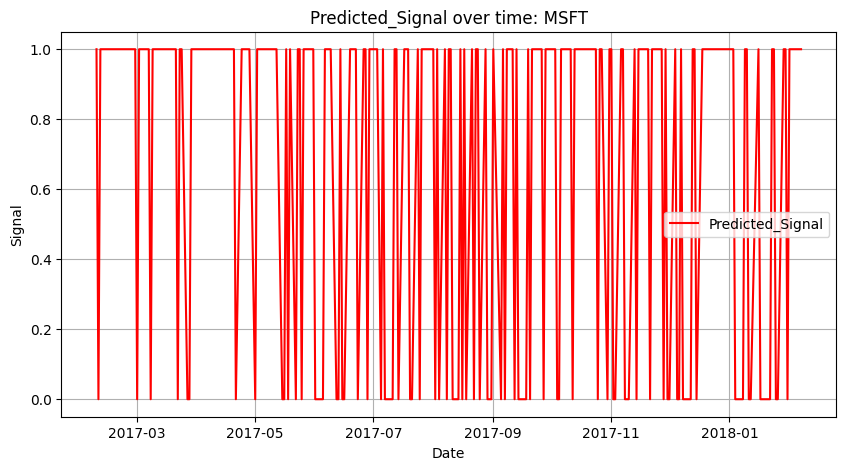

Modeling  WMT
            Open-Close  High-Low
date                            
2013-02-08       -0.28     0.570
2013-02-11       -0.15     0.980
2013-02-12        0.09     0.560
2013-02-13       -0.10     0.490
2013-02-14        0.28     0.475
...                ...       ...
2018-02-01        0.44     1.380
2018-02-02        0.67     2.320
2018-02-05        3.31     7.520
2018-02-06       -3.26     3.830
2018-02-07       -2.35     4.580

[1259 rows x 2 columns]
Test accuracy: 0.4880952380952381
Train accuracy: 0.5431976166832175
             open   high    low  close    volume Ticks  Open-Close  High-Low  \
date                                                                           
2017-02-08  66.89  67.82  66.89  67.81   7660755   WMT       -0.92      0.93   
2017-02-09  67.80  69.14  67.75  69.08  11080479   WMT       -1.28      1.39   
2017-02-10  68.25  68.60  67.76  68.02  12445633   WMT        0.23      0.84   
2017-02-13  68.32  68.65  67.56  67.77   8374307   WMT        0

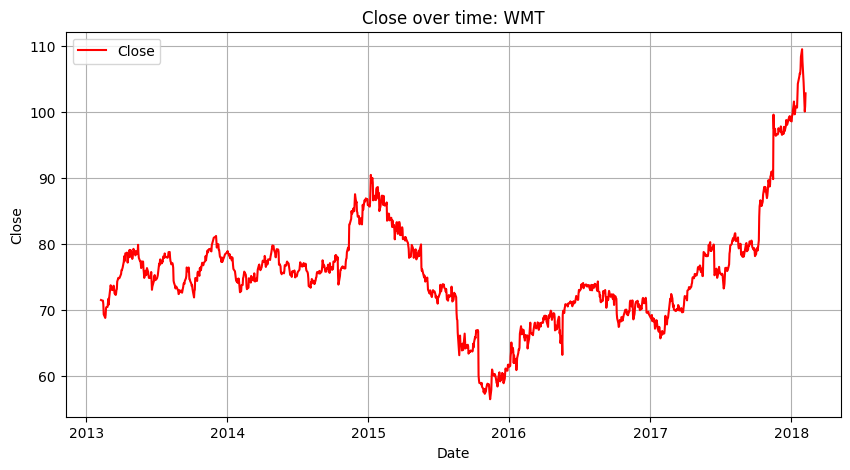

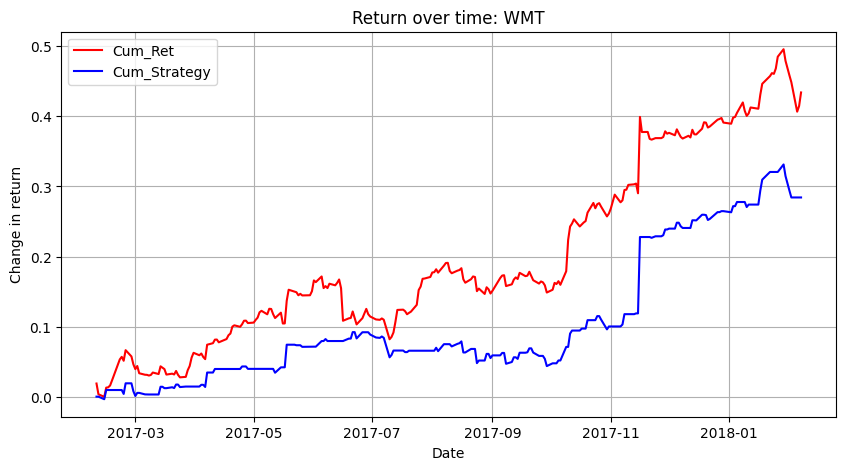

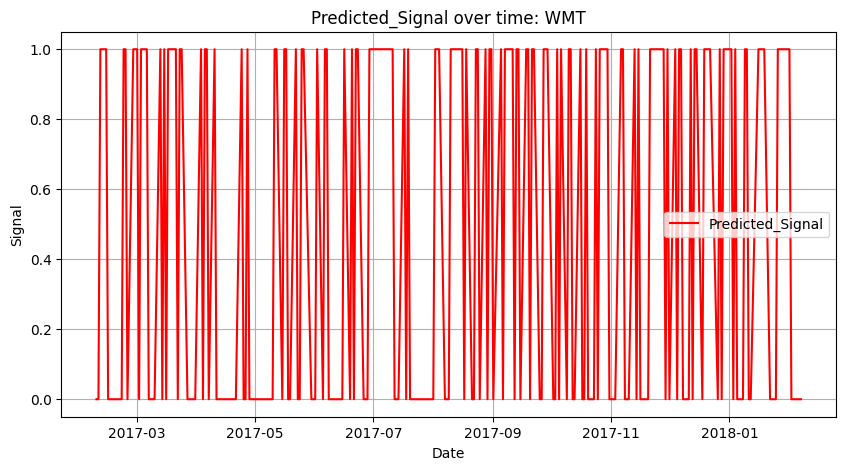

Modeling  V
            Open-Close  High-Low
date                            
2013-02-08     -0.1000    0.4600
2013-02-11      0.3125    0.5575
2013-02-12      0.0100    0.3200
2013-02-13      0.4200    0.8125
2013-02-14     -0.3450    0.5875
...                ...       ...
2018-02-01     -0.9800    2.1600
2018-02-02      2.8100    3.0200
2018-02-05      2.4300    6.1200
2018-02-06     -4.7700    7.0500
2018-02-07      0.4400    3.2500

[1259 rows x 2 columns]
Test accuracy: 0.5873015873015873
Train accuracy: 0.548162859980139
             open   high    low  close    volume Ticks  Open-Close  High-Low  \
date                                                                           
2017-02-08  85.80  85.84  85.08  85.09   7587713     V        0.71      0.76   
2017-02-09  85.37  85.77  84.88  85.58   6554731     V       -0.21      0.89   
2017-02-10  85.80  86.14  85.23  85.90  10431983     V       -0.10      0.91   
2017-02-13  86.20  86.70  86.00  86.44   6046310     V       -0.24

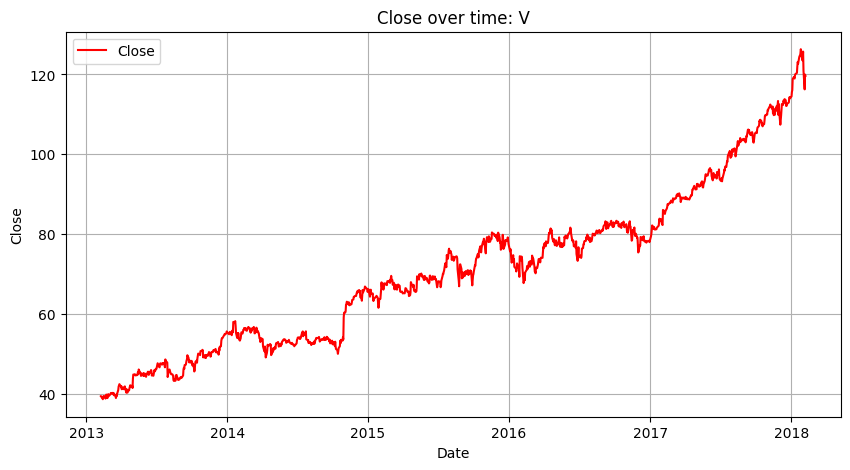

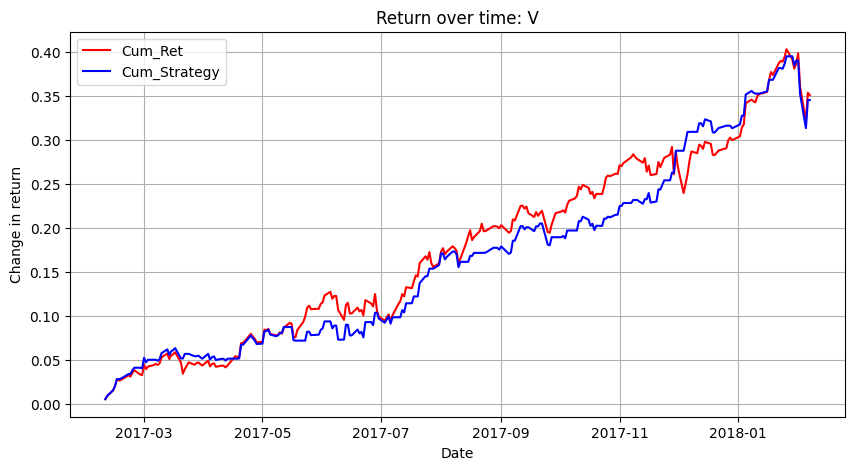

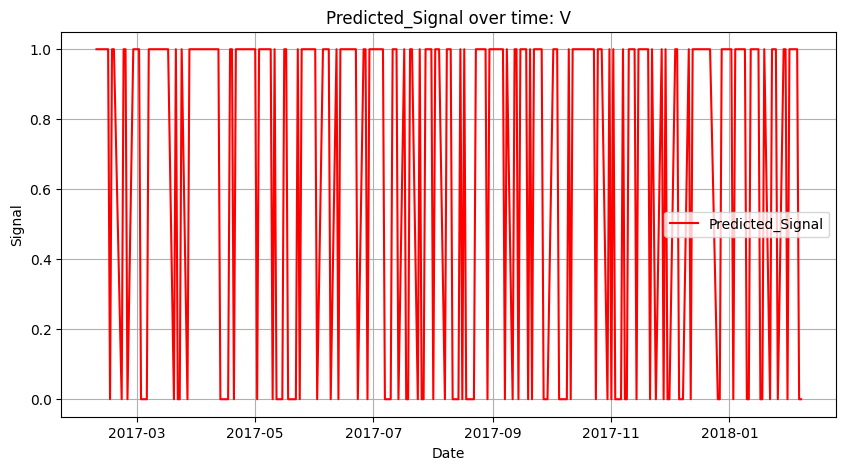

Modeling  MA
            Open-Close  High-Low
date                            
2013-02-08      -0.601    0.6160
2013-02-11       0.477    0.6925
2013-02-12       0.122    0.3620
2013-02-13       0.204    0.5720
2013-02-14      -0.601    0.7110
...                ...       ...
2018-02-01      -0.420    5.7150
2018-02-02       1.350    6.6900
2018-02-05       2.780    7.9500
2018-02-06      -8.780   12.5600
2018-02-07       0.270    5.1600

[1259 rows x 2 columns]
Test accuracy: 0.5912698412698413
Train accuracy: 0.5600794438927508
              open    high     low   close   volume Ticks  Open-Close  \
date                                                                    
2017-02-08  106.55  106.90  105.80  106.72  2993641    MA       -0.17   
2017-02-09  106.73  107.54  106.50  107.30  2679439    MA       -0.57   
2017-02-10  107.55  107.64  107.20  107.27  2078832    MA        0.28   
2017-02-13  107.70  108.33  107.54  108.28  2337277    MA       -0.58   
2017-02-14  108.01  109.21

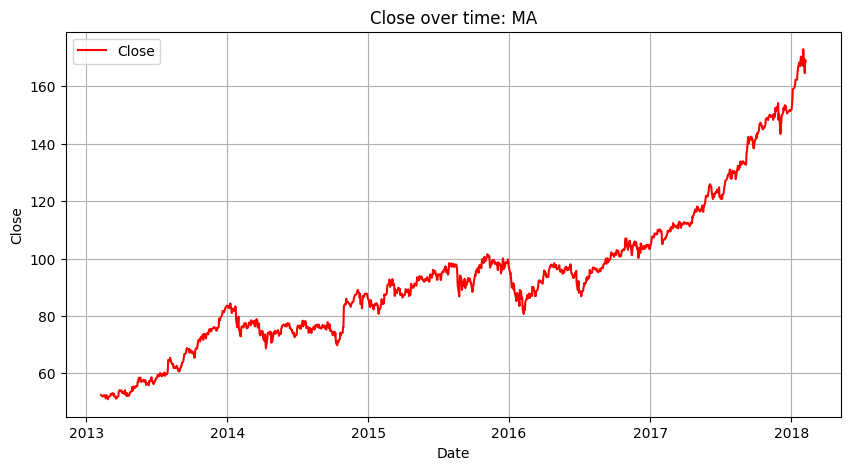

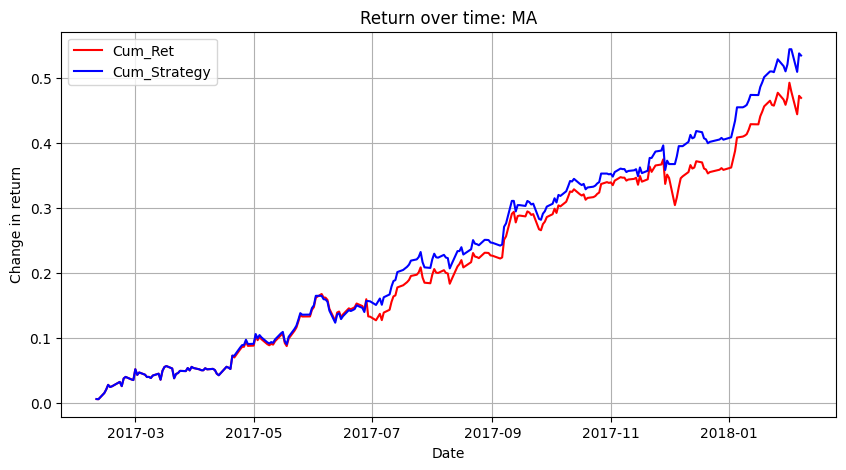

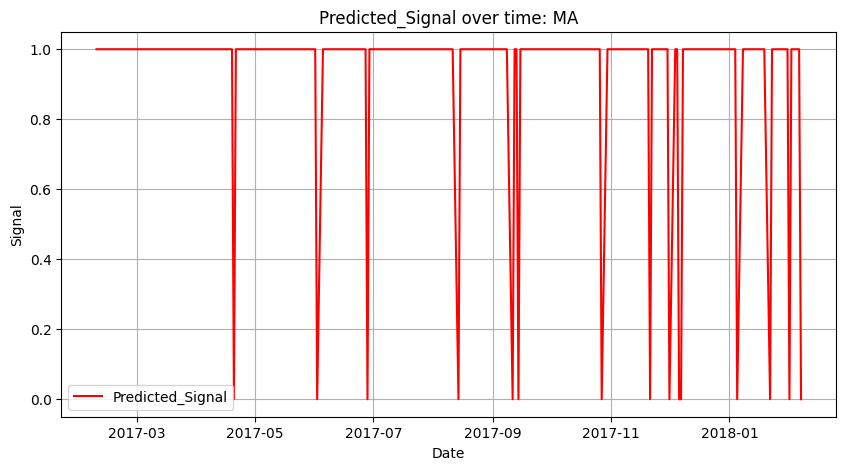

Modeling  COST
            Open-Close  High-Low
date                            
2013-02-08       -0.41     1.150
2013-02-11        0.88     1.180
2013-02-12        0.45     0.700
2013-02-13        0.35     1.420
2013-02-14       -0.98     1.048
...                ...       ...
2018-02-01       -0.06     2.960
2018-02-02        0.26     2.800
2018-02-05        7.89     9.575
2018-02-06       -6.10     9.040
2018-02-07        1.41     3.120

[1259 rows x 2 columns]
Test accuracy: 0.4722222222222222
Train accuracy: 0.5302879841112215
              open     high     low   close   volume Ticks  Open-Close  \
date                                                                     
2017-02-08  167.50  168.570  167.50  168.42  2089921  COST       -0.92   
2017-02-09  168.45  171.415  168.17  170.96  2606898  COST       -2.51   
2017-02-10  171.65  172.270  170.27  172.00  2070000  COST       -0.35   
2017-02-13  172.49  172.490  170.78  171.96  2272213  COST        0.53   
2017-02-14  171.66

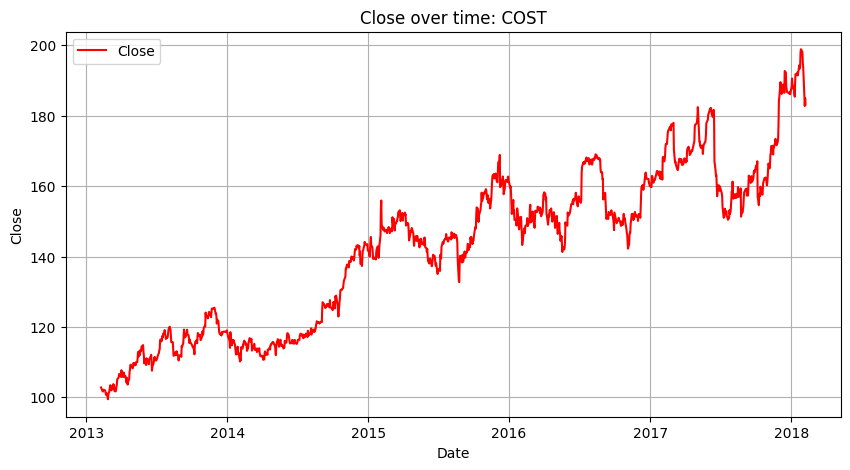

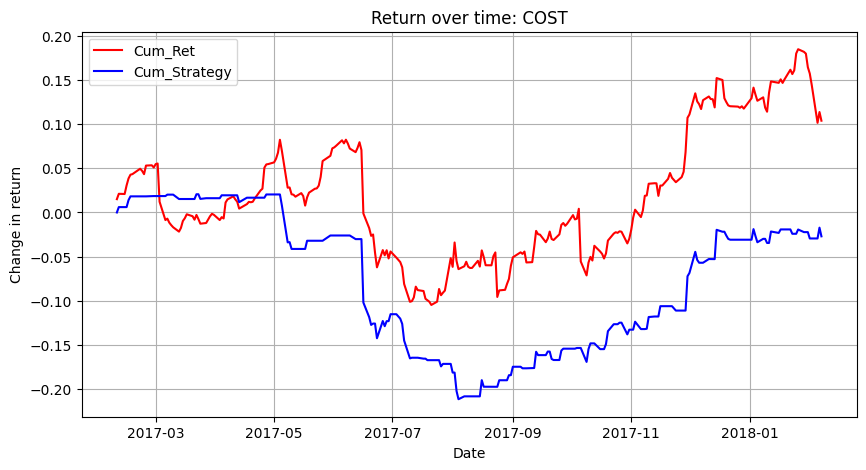

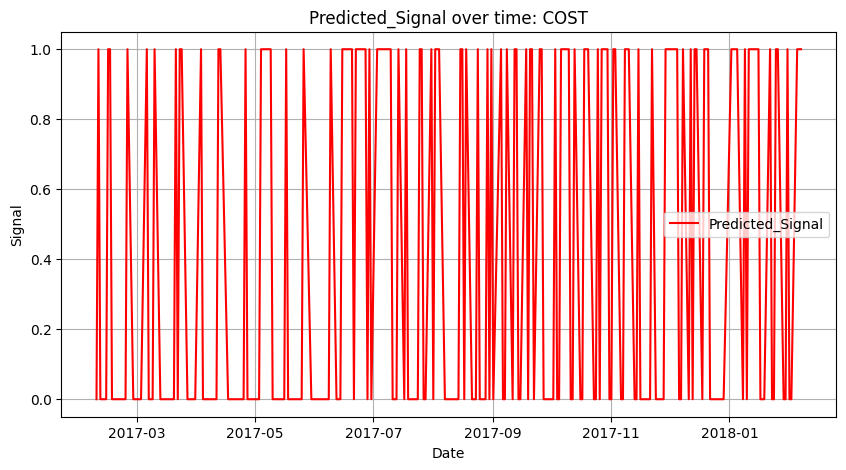

Modeling  PEP
            Open-Close  High-Low
date                            
2013-02-08        0.16    0.4000
2013-02-11        0.14    0.4400
2013-02-12        0.25    0.3900
2013-02-13        0.74    1.3900
2013-02-14       -0.16    1.7000
...                ...       ...
2018-02-01       -0.38    1.7300
2018-02-02        1.24    1.8800
2018-02-05        4.11    5.2499
2018-02-06       -1.12    3.8000
2018-02-07        0.47    3.0200

[1259 rows x 2 columns]
Test accuracy: 0.5357142857142857
Train accuracy: 0.5422045680238332
              open     high       low   close   volume Ticks  Open-Close  \
date                                                                       
2017-02-08  105.50  106.230  105.2500  105.69  3407089   PEP       -0.19   
2017-02-09  105.42  106.490  105.0200  105.97  4012387   PEP       -0.55   
2017-02-10  105.83  106.345  105.5868  106.10  2475506   PEP       -0.27   
2017-02-13  106.50  106.690  105.8800  106.52  3464318   PEP       -0.02   
2017-02

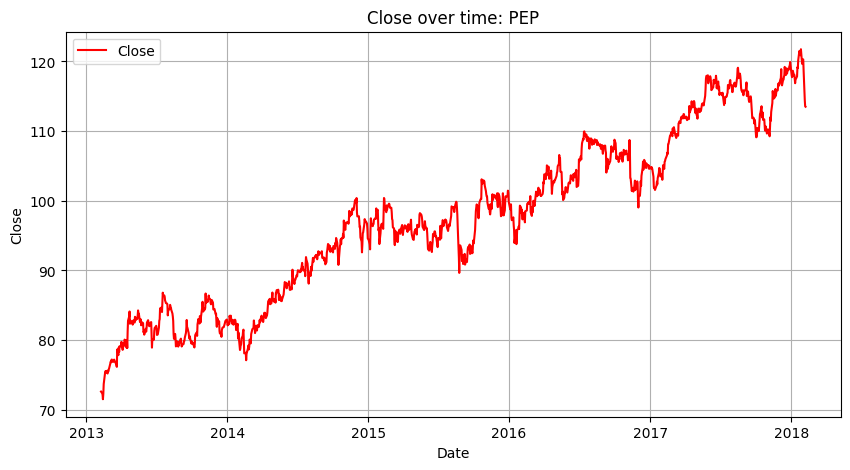

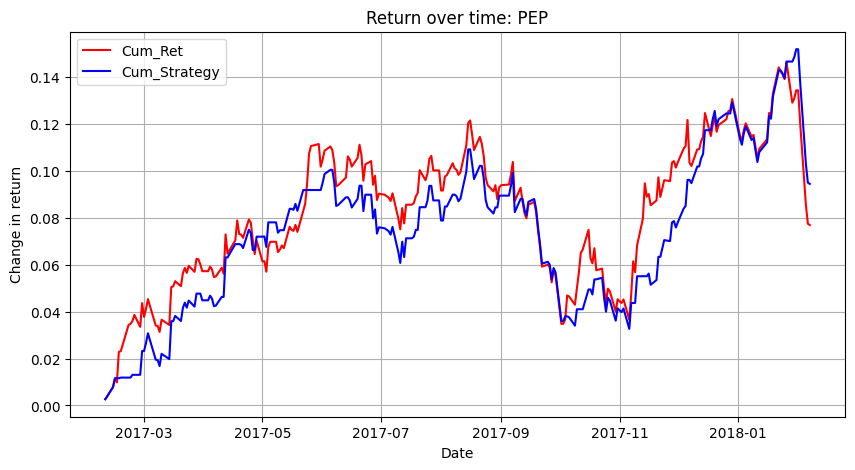

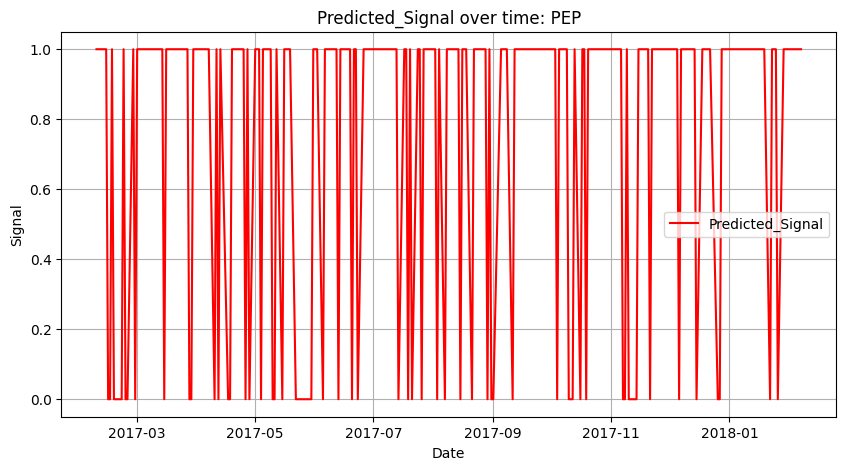

Modeling  CAT
            Open-Close  High-Low
date                            
2013-02-08       -0.75    1.4000
2013-02-11        0.36    0.6900
2013-02-12       -0.55    0.7400
2013-02-13        0.71    1.4800
2013-02-14       -0.01    1.0000
...                ...       ...
2018-02-01       -1.00    3.5600
2018-02-02        3.28    4.2700
2018-02-05        3.85   16.0800
2018-02-06       -8.34    9.7499
2018-02-07        1.02    3.8100

[1259 rows x 2 columns]
Test accuracy: 0.4444444444444444
Train accuracy: 0.5322740814299901
             open    high    low  close   volume Ticks  Open-Close  High-Low  \
date                                                                           
2017-02-08  93.00  93.000  92.11  92.91  4083514   CAT        0.09     0.890   
2017-02-09  93.06  94.180  92.69  93.96  3994308   CAT       -0.90     1.490   
2017-02-10  94.87  96.620  94.50  96.31  5600224   CAT       -1.44     2.120   
2017-02-13  97.69  99.045  97.16  98.50  6995085   CAT       -0

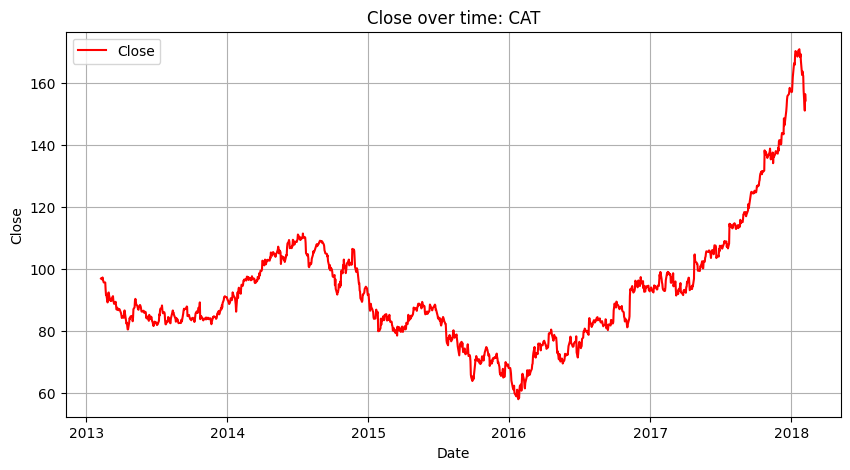

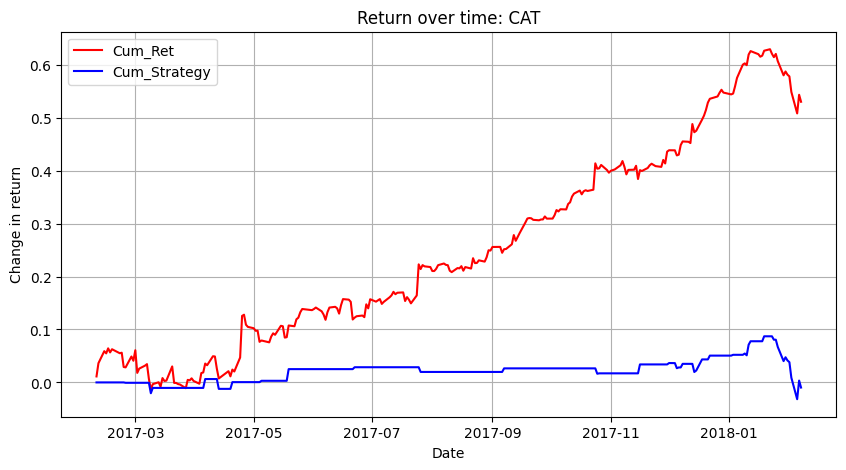

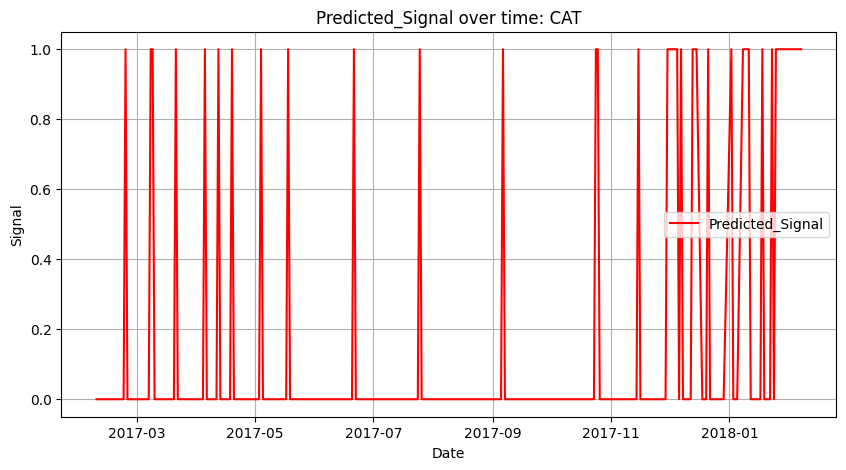

Modeling  WM
            Open-Close  High-Low
date                            
2013-02-08       -0.09    0.5255
2013-02-11        0.00    0.2000
2013-02-12       -0.16    0.2900
2013-02-13       -0.12    0.3772
2013-02-14       -1.15    1.9400
...                ...       ...
2018-02-01        0.62    1.2200
2018-02-02        0.73    1.5500
2018-02-05        4.35    4.7200
2018-02-06       -0.89    4.0990
2018-02-07        0.15    1.8400

[1259 rows x 2 columns]
Test accuracy: 0.5634920634920635
Train accuracy: 0.548162859980139
             open    high    low  close   volume Ticks  Open-Close  High-Low  \
date                                                                           
2017-02-08  69.85  70.130  69.75  70.01  1604552    WM       -0.16     0.380   
2017-02-09  69.89  70.305  69.74  70.25  1512116    WM       -0.36     0.565   
2017-02-10  70.16  70.830  70.04  70.54  1617277    WM       -0.38     0.790   
2017-02-13  70.59  70.990  70.51  70.84  1548833    WM       -0.2

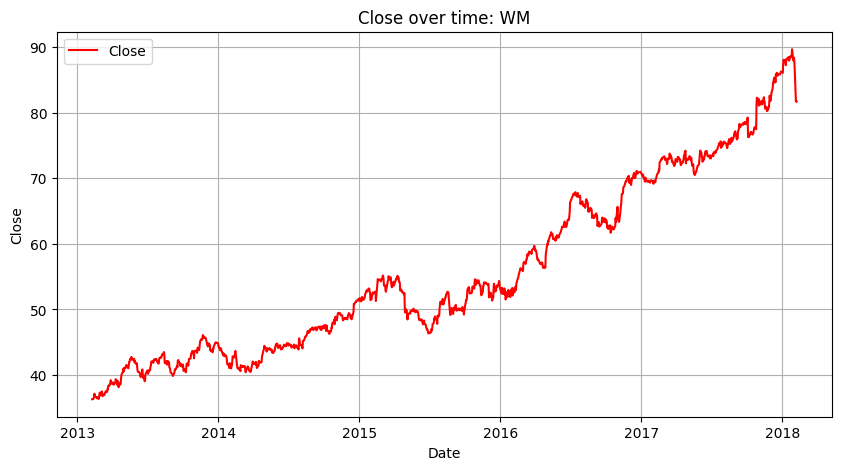

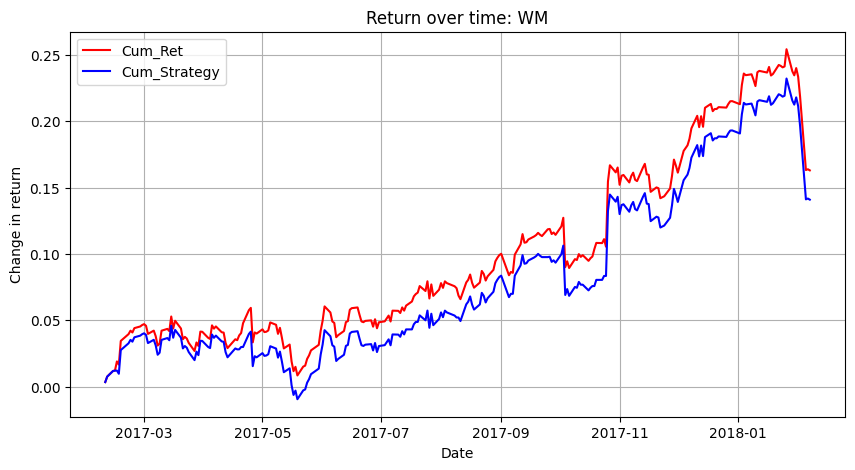

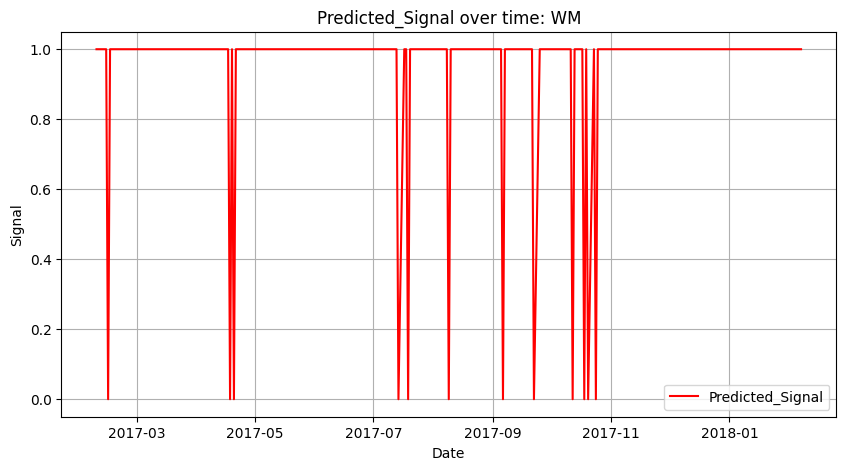

Modeling  ITW
            Open-Close  High-Low
date                            
2013-02-08       -0.82    0.9400
2013-02-11       -0.10    0.4500
2013-02-12       -0.15    0.4600
2013-02-13       -0.34    0.6460
2013-02-14       -0.15    0.4699
...                ...       ...
2018-02-01       -0.48    2.9199
2018-02-02        1.53    3.4000
2018-02-05        8.41   10.8700
2018-02-06       -5.93    8.7390
2018-02-07        0.21    4.5300

[1259 rows x 2 columns]
Test accuracy: 0.5833333333333334
Train accuracy: 0.551142005958292
              open    high     low   close   volume Ticks  Open-Close  \
date                                                                    
2017-02-08  126.92  127.39  126.52  127.12   759251   ITW       -0.20   
2017-02-09  127.30  128.26  127.15  127.26  1164117   ITW        0.04   
2017-02-10  127.64  128.10  127.18  128.00   725736   ITW       -0.36   
2017-02-13  128.34  129.64  128.34  129.37   897696   ITW       -1.03   
2017-02-14  129.30  129.71

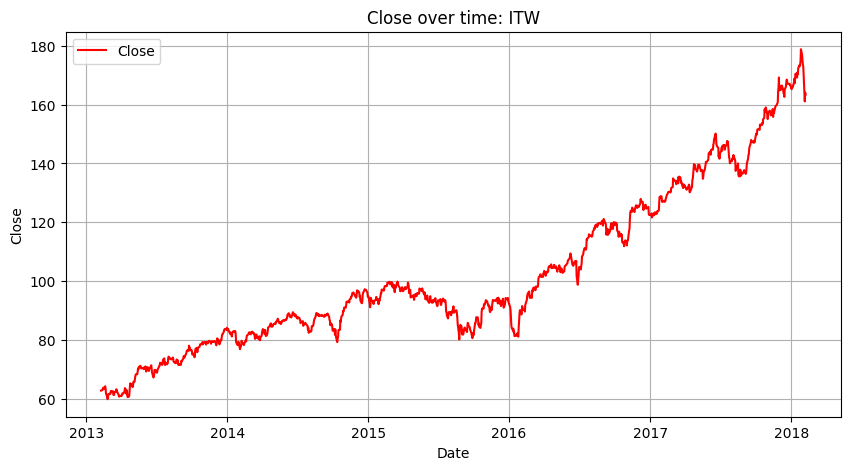

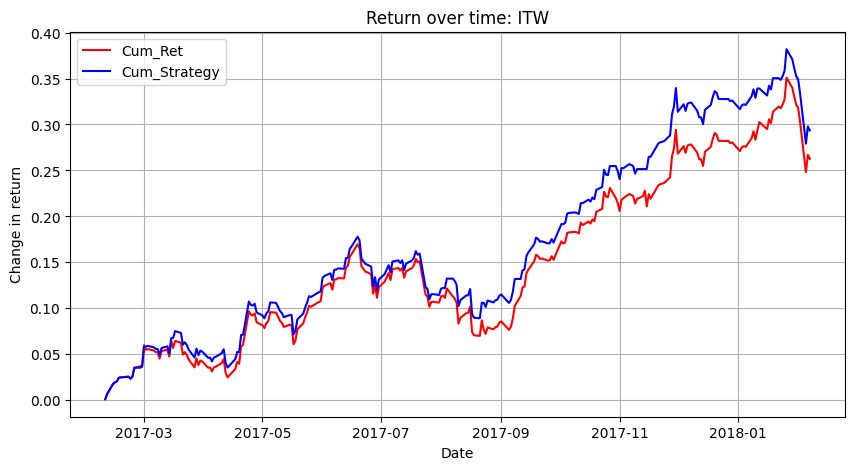

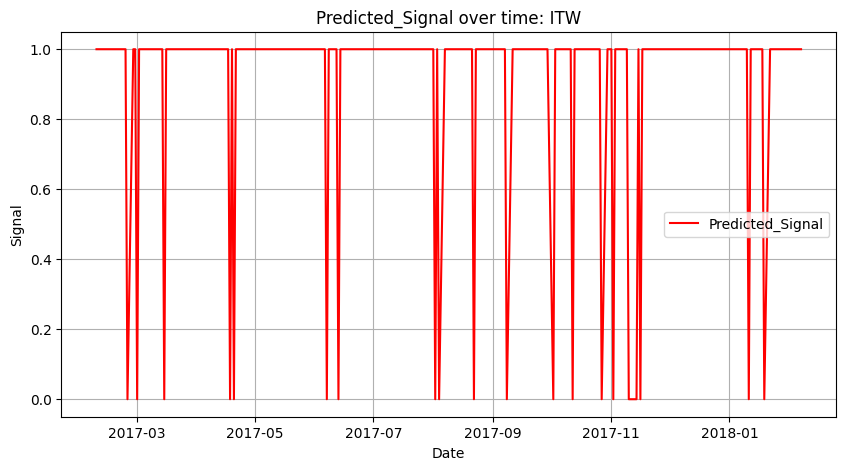

In [10]:
###############
# Section three
###############

# Try this by looping through multiple stock symbols

# Either pick a few stocks to try
tick_names = ['AMZN', 'AAPL', 'MSFT', 'WMT', 'V', 'MA', 'COST', 'PEP', 'CAT', 'WM', 'ITW']

# OR do it for all stocks
#tick_names = unique_values

# Train a model for each stock
for name in tick_names:
    print("Modeling ", name)
    stock = df.loc[df['Ticks'] == name]
    stock.index = pd.to_datetime(stock['date']) 

    stock = stock.drop(['date'], axis='columns') 
    stock['Open-Close'] = stock['open'] - stock['close']
    stock['High-Low'] = stock['high'] - stock['low']
      
    # Store all predictor variables in a variable X 
    X = stock[['Open-Close', 'High-Low']] 

    X_cleaned = X[~np.isnan(X).any(axis=1)]
    print(X)
    y = np.where(stock['close'].shift(-1) > stock['close'], 1, 0) 
    split_percentage = 0.8
    split = int(split_percentage*len(stock)) 
      
    # Train data set 
    X_train = X[:split] 
    y_train = y[:split] 
      
    # Test data set 
    X_test = X[split:] 
    y_test = y[split:]

    svm = SVC()
    cls = svm.fit(X_train, y_train)
    
    y_pred = cls.predict(X_test)
    y_pred_train = cls.predict(X_train)

    accuracy = accuracy_score(y_test, y_pred)
    print("Test accuracy:", accuracy)
    
    accuracy = accuracy_score(y_train, y_pred_train)
    print("Train accuracy:", accuracy)

    # Only show the returns of the test period:

    stock_future = stock[split:]

    stock_future['Predicted_Signal'] = cls.predict(X_test)
    stock_future['Return'] = stock_future['close'].pct_change()
    stock_future['Strategy_Return'] = stock_future.Return * stock_future.Predicted_Signal.shift(1)
    stock_future['Cum_Ret'] = stock_future['Return'].cumsum() 
    stock_future['Cum_Strategy'] = stock_future['Strategy_Return'].cumsum() 

    print(stock_future.head())

    plt.figure(figsize=(10, 5))
    plt.plot(stock['close'],color='red', label="Close") 
    plt.title('Close over time: ' + name, )
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(stock_future['Cum_Ret'],color='red', label="Cum_Ret") 
    plt.plot(stock_future['Cum_Strategy'],color='blue', label="Cum_Strategy")
    plt.title('Return over time: ' + name, )
    plt.xlabel('Date')
    plt.ylabel('Change in return')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(stock_future['Predicted_Signal'],color='red', label="Predicted_Signal") 
    plt.title('Predicted_Signal over time: ' + name, )
    plt.xlabel('Date')
    plt.ylabel('Signal')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
# Try this by looping through multiple stock symbols

# Pick a few stocks
tick_names = ["MSFT", "ADBE", "AMZN", "GOOGL", "GOOG", "AAPL", "V", "MA", 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP',
        'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY', 'BDX', 'BEN', 'BF.B',
        'BIIB', 'BK', 'BLK', 'BLL', 'BMY', 'BRK.B', 'BSX',
        'HP', 'HRB', 'HRL', 'HRS', 'HSIC', 'HST', 'HSY', 'HUM', 'IBM', 'ICE', 'IDXX', 'IFF',
        'ILMN', 'INCY','NAVI', 'NBL', 'NCLH', 'NDAQ', 'NEE', 'NEM', 'NFLX', 'NFX', 'NI', 'NKE', 'NLSN',
        'NOC', 'NOV', 'NRG', 'NSC', 'NTAP', 'NUE', 'NVDA', 'NWL', 'NWSA', 'NWS',
        'OKE', 'OMC', 'ORCL',
                     'WY', 'XEC', 'XEL', 'XLNX', 'XL', 'XRAY', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZION',
        'ZTS']

neg_mark = 0
better_than_neg = 0

neg_avg = 0
neg_pred_avg = 0

import random

# Perform random splits to see out out strategy compares to other strategies
for random_split in range(0,100):

    random_split = random.uniform(0.5, 0.9)

    print(random_split)

    market_return = [0, 0, 0, 0, 0, 0]
    strat_return = [0, 0, 0, 0, 0, 0]

    # Train a model for each stock
    for name in tick_names:
        stock = df.loc[df['Ticks'] == name]
        stock.index = pd.to_datetime(stock['date']) 
    
        stock = stock.drop(['date'], axis='columns') 
        stock['Open-Close'] = stock['open'] - stock['close']
        stock['High-Low'] = stock['high'] - stock['low']
          
        # Store all predictor variables in a variable X 
        X = stock[['Open-Close', 'High-Low']] 
    
        y = np.where(stock['close'].shift(-1) > stock['close'], 1, 0) 
        split_percentage = random_split
        split = int(split_percentage*len(X)) 
          
        # Train data set 
        X_train = X[:split] 
        y_train = y[:split] 
          
        # Test data set 
        X_test = X[split:] 
        y_test = y[split:]
    
        svm = SVC()
        cls = svm.fit(X_train, y_train)
        
        y_pred = cls.predict(X_test)
        y_pred_train = cls.predict(X_train)
 
        # Only show the returns of the test period:
    
        stock_future = stock[split:]
    
        stock_future['Predicted_Signal'] = cls.predict(X_test)
        stock_future['Return'] = stock_future['close'].pct_change()
        stock_future['Strategy_Return'] = stock_future.Return * stock_future.Predicted_Signal.shift(1)
        stock_future['Cum_Ret'] = stock_future['Return'].cumsum() 
        stock_future['Cum_Strategy'] = stock_future['Strategy_Return'].cumsum() 
    
        # Compare returns for these days
        day0 = stock_future.iloc[0]['Cum_Ret']
        day1 = stock_future.iloc[1]['Cum_Ret']
        day3 = stock_future.iloc[3]['Cum_Ret']
        day5 = stock_future.iloc[5]['Cum_Ret']
        day10 = stock_future.iloc[10]['Cum_Ret']
        day15 = stock_future.iloc[15]['Cum_Ret']
    
        strat_day0 = stock_future.iloc[0]['Cum_Strategy']
        strat_day1 = stock_future.iloc[1]['Cum_Strategy']
        strat_day3 = stock_future.iloc[3]['Cum_Strategy']
        strat_day5 = stock_future.iloc[5]['Cum_Strategy']
        strat_day10 = stock_future.iloc[10]['Cum_Strategy']
        strat_day15 = stock_future.iloc[15]['Cum_Strategy']

        market_return[0] += day0
        market_return[1] += day1
        market_return[2] += day3
        market_return[3] += day5
        market_return[4] += day10
        market_return[5] += day15

        strat_return[0] += strat_day0
        strat_return[1] += strat_day1
        strat_return[2] += strat_day3
        strat_return[3] += strat_day5
        strat_return[4] += strat_day10
        strat_return[5] += strat_day15
    
    if (market_return[1] < 0):
        neg_mark += 1
        neg_avg += market_return[1]
        neg_pred_avg += strat_return[1]
        if (market_return[1] < strat_return[1]):
            better_than_neg += 1
        
    
    print("Final returns!!")
    
    print(market_return)
    print(strat_return)
    print("Neg market: ", neg_mark)
    print("Better than negative market: ", better_than_neg)

    if neg_mark > 0:
        print("Neg market avg: ", neg_avg / neg_mark)
        print("Better than negative market avg: ", neg_pred_avg / neg_mark)
    

0.865107968014662
Final returns!!
[nan, 0.010437216517958592, -0.18223028320003576, 0.1634495247561487, 0.2843275360720521, 0.9815514212506504]
[nan, 0.021081553357777172, -0.4903495788470642, -0.057730697902000694, 0.29115351000862966, 0.7972890095377035]
Neg market:  0
Better than negative market:  0
0.6603845652766608
Final returns!!
[nan, -0.0009338111752529299, 0.2905525143374891, 0.6820065269033277, -0.5839901852612438, -0.14270137510420722]
[nan, -0.04156785599408419, 0.1938936943341255, 0.5590576483077808, -0.34697173593665764, -0.07750619048652574]
Neg market:  1
Better than negative market:  0
Neg market avg:  -0.0009338111752529299
Better than negative market avg:  -0.04156785599408419
0.8600157971885916
Final returns!!
[nan, -0.13496592751090297, 0.5759131946664252, 0.4619322243489612, -0.005595244495666507, 0.9811172243912539]
[nan, -0.02182609833976057, 0.5415593041764214, 0.5880122904668065, 0.021391549602489235, 0.9524551147529993]
Neg market:  2
Better than negative ma